In [688]:
import pandas as pd
import re
import datetime as dt

In [689]:
try:
    df = pd.read_csv('datasets/car_data.csv')
except Exception:
    df = pd.read_csv('/datasets/car_data.csv')

In [690]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [691]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [692]:
df.columns = [camel_to_snake(col) for col in df.columns]

In [693]:
# rename power column to horsepower
df.rename(columns={'power': 'horsepower'}, inplace=True)

In [694]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [695]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   horsepower          354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [696]:
df.describe()

,price,registration_year,horsepower,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [697]:
df.drop(['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created', 'registration_month'], axis=1, inplace=True)

In [698]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   horsepower         354369 non-null  int64 
 5   model              334664 non-null  object
 6   mileage            354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   not_repaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [699]:
df.describe()

,price,registration_year,horsepower,mileage
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [700]:
df.price.describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

<Axes: >

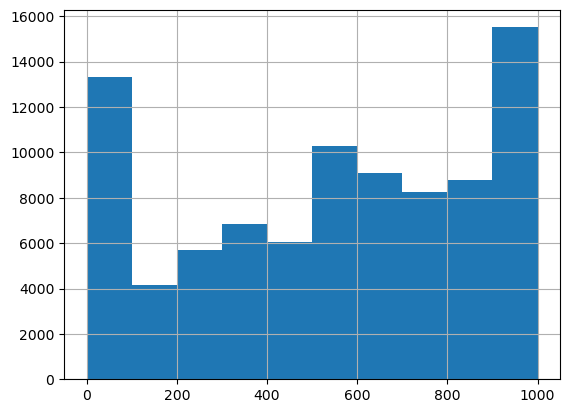

In [701]:
df[df['price'] <= 1000].price.hist()

In [702]:
# drop rows with price <= 100
df = df[df['price'] > 100]

In [703]:
df.vehicle_type.describe()

count     307773
unique         8
top        sedan
freq       88965
Name: vehicle_type, dtype: object

In [704]:
df.vehicle_type.value_counts()

vehicle_type
sedan          88965
small          77029
wagon          63384
bus            28256
convertible    19807
coupe          15534
suv            11758
other           3040
Name: count, dtype: int64

In [705]:
# replace null values with most frequent value of matching brand and model
df.vehicle_type = df.groupby(['brand', 'model'])['vehicle_type'].transform(lambda x: x.fillna(x.mode()[0]))

In [706]:
df.head()

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,NaN,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [707]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340024 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              340024 non-null  int64 
 1   vehicle_type       323135 non-null  object
 2   registration_year  340024 non-null  int64 
 3   gearbox            323939 non-null  object
 4   horsepower         340024 non-null  int64 
 5   model              323135 non-null  object
 6   mileage            340024 non-null  int64 
 7   fuel_type          312020 non-null  object
 8   brand              340024 non-null  object
 9   not_repaired       276157 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.5+ MB


In [708]:
df[df['model'].isnull()].sample(20)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
309737,5490,NaN,1998,manual,65,NaN,70000,petrol,sonstige_autos,NaN
41780,19499,NaN,2009,auto,260,NaN,70000,lpg,sonstige_autos,no
248674,3150,NaN,2003,auto,0,NaN,150000,NaN,opel,NaN
244946,10500,NaN,2016,manual,265,NaN,150000,petrol,audi,no
250933,1100,NaN,2002,auto,45,NaN,150000,gasoline,smart,no
296168,550,NaN,2001,manual,75,NaN,150000,petrol,renault,yes
133231,3700,NaN,2000,manual,150,NaN,150000,petrol,bmw,no
31512,250,NaN,2000,NaN,0,NaN,5000,petrol,renault,NaN
192566,8000,NaN,2004,auto,333,NaN,150000,petrol,bmw,no
346840,350,NaN,1996,manual,75,NaN,150000,NaN,opel,no


In [709]:
# drop rows with null values in model column
df = df[df['vehicle_type'].notnull()]

In [710]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323135 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              323135 non-null  int64 
 1   vehicle_type       323135 non-null  object
 2   registration_year  323135 non-null  int64 
 3   gearbox            309754 non-null  object
 4   horsepower         323135 non-null  int64 
 5   model              323135 non-null  object
 6   mileage            323135 non-null  int64 
 7   fuel_type          300604 non-null  object
 8   brand              323135 non-null  object
 9   not_repaired       266369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.1+ MB


In [711]:
df.registration_year.describe()

count    323135.000000
mean       2003.803104
std          55.795947
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

<Axes: >

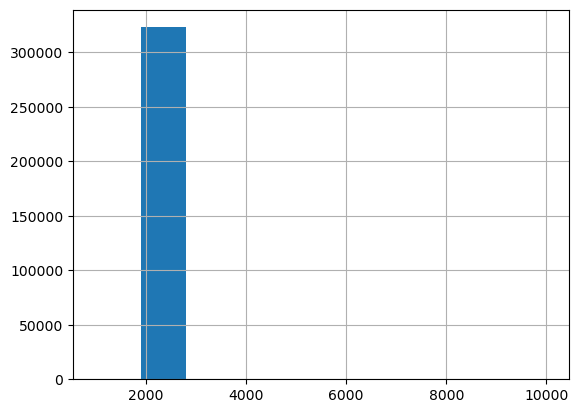

In [712]:
# plot histogram of registration year
df.registration_year.hist()

In [713]:
df[df['registration_year'] < 1950].registration_year.value_counts()

registration_year
1910    17
1000    10
1937     7
1945     3
1938     3
1943     3
1929     3
1936     3
1932     3
1942     2
1933     2
1800     2
1923     2
1930     2
1947     2
1300     2
1935     2
1928     2
1931     1
1602     1
1927     1
1234     1
1941     1
1934     1
1001     1
1400     1
1949     1
1500     1
1600     1
Name: count, dtype: int64

In [714]:
display(df[df['registration_year'] <= 1900])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
16062,190,wagon,1000,NaN,0,mondeo,5000,NaN,ford,NaN
18224,7999,sedan,1500,manual,224,impreza,5000,NaN,subaru,NaN
53577,330,small,1000,NaN,0,polo,5000,NaN,volkswagen,NaN
56241,950,sedan,1400,manual,1400,golf,125000,petrol,volkswagen,NaN
71459,500,sedan,1000,NaN,0,golf,5000,NaN,volkswagen,NaN
79120,4750,bus,1000,NaN,0,other,5000,NaN,renault,NaN
97736,140,coupe,1000,NaN,0,911,5000,NaN,porsche,NaN
125577,7750,bus,1001,NaN,0,other,5000,NaN,citroen,NaN
129768,275,sedan,1234,NaN,0,e_klasse,5000,NaN,mercedes_benz,NaN
143621,550,sedan,1000,NaN,1000,golf,5000,petrol,volkswagen,NaN


In [715]:
df[df['registration_year'] > 2016].registration_year.value_counts()

registration_year
2017    8536
2018    3240
2019      13
5000      10
9999       8
7000       3
4000       3
5555       2
5911       2
3000       2
9000       1
8200       1
7100       1
7800       1
4500       1
6000       1
2290       1
2200       1
2900       1
3700       1
8500       1
2066       1
5900       1
2500       1
Name: count, dtype: int64

In [716]:
display(df[df['registration_year'] == 2018])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
22,2900,bus,2018,manual,90,meriva,150000,petrol,opel,no
57,2399,other,2018,manual,64,other,125000,NaN,seat,no
163,1200,sedan,2018,manual,75,astra,150000,NaN,opel,no
196,2800,small,2018,manual,75,twingo,125000,NaN,renault,no
355,1050,sedan,2018,NaN,0,golf,150000,NaN,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
353824,2500,sedan,2018,manual,125,a_klasse,150000,petrol,mercedes_benz,no
353825,1600,small,2018,manual,0,lupo,5000,petrol,volkswagen,no
353918,999,sedan,2018,NaN,0,golf,150000,NaN,volkswagen,no
354203,2140,small,2018,manual,80,fiesta,150000,NaN,ford,no


In [717]:
# drop rows with registration year < 1900 or > 2016
df = df[df['registration_year'].between(1900, 2016)]

In [718]:
df.gearbox.value_counts()

gearbox
manual    239223
auto       60026
Name: count, dtype: int64

In [719]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311282 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              311282 non-null  int64 
 1   vehicle_type       311282 non-null  object
 2   registration_year  311282 non-null  int64 
 3   gearbox            299249 non-null  object
 4   horsepower         311282 non-null  int64 
 5   model              311282 non-null  object
 6   mileage            311282 non-null  int64 
 7   fuel_type          293019 non-null  object
 8   brand              311282 non-null  object
 9   not_repaired       259572 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.1+ MB


In [720]:
df[df['gearbox'].isnull()].sample(20)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
219222,950,small,2000,NaN,0,twingo,150000,NaN,renault,no
215129,4200,convertible,2006,NaN,61,fortwo,80000,petrol,smart,no
104488,1500,wagon,2003,NaN,90,berlingo,150000,gasoline,citroen,NaN
325656,5300,sedan,2004,NaN,163,c_klasse,90000,petrol,mercedes_benz,no
31471,7900,convertible,1980,NaN,105,other,125000,NaN,fiat,NaN
315913,3100,sedan,2007,NaN,0,passat,150000,gasoline,volkswagen,no
181943,3888,wagon,2002,NaN,163,5er,150000,gasoline,bmw,NaN
268653,3200,small,2005,NaN,0,c2,150000,NaN,citroen,NaN
60956,780,small,1999,NaN,0,other,125000,NaN,smart,yes
193593,350,small,2005,NaN,0,fortwo,150000,petrol,smart,NaN


In [721]:
display(df[df['model'] == 'other'].gearbox.value_counts())

gearbox
manual    16967
auto       4895
Name: count, dtype: int64

In [722]:
# assume that vehicles with null gearbox values are manual
df.gearbox = df.gearbox.fillna('manual')

In [723]:
df.horsepower.describe()

count    311282.000000
mean        113.361817
std         179.921233
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: horsepower, dtype: float64

In [724]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311282 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              311282 non-null  int64 
 1   vehicle_type       311282 non-null  object
 2   registration_year  311282 non-null  int64 
 3   gearbox            311282 non-null  object
 4   horsepower         311282 non-null  int64 
 5   model              311282 non-null  object
 6   mileage            311282 non-null  int64 
 7   fuel_type          293019 non-null  object
 8   brand              311282 non-null  object
 9   not_repaired       259572 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.1+ MB


In [725]:
df[df['horsepower'] < 20].horsepower.value_counts()

horsepower
0     27235
18       47
11       21
1        17
5        13
19       11
12        9
15        9
14        8
10        7
17        7
4         5
8         5
2         4
13        4
16        4
6         4
7         3
9         2
3         1
Name: count, dtype: int64

In [726]:
display(df[df['horsepower'] == 5])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
33995,4999,small,2012,auto,5,other,5000,electric,renault,no
34378,655,other,1995,manual,5,other,70000,NaN,seat,NaN
59478,999,convertible,1995,manual,5,punto,125000,petrol,fiat,no
78193,999,small,2000,manual,5,twingo,150000,petrol,renault,NaN
118004,6500,bus,2006,manual,5,5_reihe,150000,petrol,mazda,no
134171,1790,sedan,2002,manual,5,corsa,150000,petrol,opel,no
138316,360,small,1999,manual,5,twingo,150000,petrol,renault,NaN
146998,650,bus,1998,manual,5,kangoo,150000,petrol,renault,no
154878,500,small,2016,manual,5,lupo,150000,petrol,volkswagen,no
180367,700,small,2001,manual,5,polo,150000,petrol,volkswagen,no


In [727]:
df[df['horsepower'] == 0].sample(20)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
314350,700,sedan,1997,auto,0,a4,150000,NaN,audi,yes
249709,1200,wagon,2001,auto,0,a6,150000,gasoline,audi,no
345265,1800,small,2004,manual,0,c2,150000,gasoline,citroen,no
176574,18700,wagon,2013,manual,0,passat,60000,gasoline,volkswagen,no
285081,1559,small,2016,manual,0,polo,150000,petrol,volkswagen,no
137565,1650,wagon,1997,auto,0,e_klasse,150000,petrol,mercedes_benz,no
218853,3490,bus,2007,manual,0,kangoo,150000,gasoline,renault,no
259453,1500,sedan,2001,manual,0,punto,80000,petrol,fiat,NaN
81529,400,sedan,1991,manual,0,jetta,150000,petrol,volkswagen,yes
276757,399,sedan,2000,manual,0,a_klasse,150000,petrol,mercedes_benz,NaN


In [728]:
# fill horsepower zero values with median non-zero horsepower of matching brand and model and year
df.horsepower = df.groupby(['brand', 'model', 'registration_year'])['horsepower'].transform(lambda x: x.replace(0, x[x > 0].median()))

# drop null horsepower values (which were zero before), then convert back to int
df.dropna(subset=['horsepower'], inplace=True)
df.horsepower = df.horsepower.astype('int')

In [729]:
df.describe()

,price,registration_year,horsepower,mileage
count,310935.000000,310935.000000,310935.000000,310935.000000
mean,4714.847103,2002.797765,122.459475,128561.419589
std,4557.786973,6.519039,177.105700,36784.699755
min,101.000000,1910.000000,1.000000,5000.000000
25%,1280.000000,1999.000000,75.000000,125000.000000
50%,2999.000000,2003.000000,110.000000,150000.000000
75%,6800.000000,2007.000000,147.000000,150000.000000
max,20000.000000,2016.000000,20000.000000,150000.000000


In [730]:
df[df['horsepower'] < 20].horsepower.value_counts()

horsepower
18    59
11    21
1     19
19    13
5     13
15    10
12     9
14     9
10     7
17     7
4      5
8      5
2      4
16     4
6      4
13     4
7      3
9      2
3      1
Name: count, dtype: int64

In [731]:
# drop rows with horsepower < 10
df = df[df['horsepower'] >= 10]

In [732]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310879 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              310879 non-null  int64 
 1   vehicle_type       310879 non-null  object
 2   registration_year  310879 non-null  int64 
 3   gearbox            310879 non-null  object
 4   horsepower         310879 non-null  int64 
 5   model              310879 non-null  object
 6   mileage            310879 non-null  int64 
 7   fuel_type          292781 non-null  object
 8   brand              310879 non-null  object
 9   not_repaired       259366 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.1+ MB


In [733]:
display(df[df['horsepower'] > 600])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,NaN
...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,NaN
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN


In [734]:
# if horsepower > 600, replace with median horsepower of matching brand and model
df.horsepower = df.groupby(['brand', 'model'])['horsepower'].transform(lambda x: x.replace(x[x > 600].median()))

In [735]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310879 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              310879 non-null  int64 
 1   vehicle_type       310879 non-null  object
 2   registration_year  310879 non-null  int64 
 3   gearbox            310879 non-null  object
 4   horsepower         310879 non-null  int64 
 5   model              310879 non-null  object
 6   mileage            310879 non-null  int64 
 7   fuel_type          292781 non-null  object
 8   brand              310879 non-null  object
 9   not_repaired       259366 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.1+ MB


In [736]:
df.fuel_type.value_counts()

fuel_type
petrol      195056
gasoline     92149
lpg           4706
cng            508
hybrid         197
other          105
electric        60
Name: count, dtype: int64

In [737]:
display(df[df['fuel_type'].isnull()])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
13,2500,wagon,2004,manual,131,passat,150000,NaN,volkswagen,no
36,1600,other,1991,manual,75,kadett,70000,NaN,opel,NaN
41,7500,sedan,2002,auto,306,e_klasse,150000,NaN,mercedes_benz,NaN
52,1400,small,2016,manual,55,other,5000,NaN,hyundai,NaN
...,...,...,...,...,...,...,...,...,...,...
354327,2999,wagon,2004,manual,234,vectra,100000,NaN,opel,NaN
354329,350,small,1996,manual,65,punto,150000,NaN,fiat,NaN
354339,3850,convertible,2006,manual,108,2_reihe,125000,NaN,peugeot,no
354346,2600,sedan,2005,auto,150,c_klasse,150000,NaN,mercedes_benz,NaN


In [738]:
# replace gasoline with petrol
df.fuel_type = df.fuel_type.replace('gasoline', 'petrol')

In [739]:
# replace null values in fuel type with most frequent value of matching brand and model
df.fuel_type = df.groupby(['brand', 'model'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0]))

In [740]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310879 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              310879 non-null  int64 
 1   vehicle_type       310879 non-null  object
 2   registration_year  310879 non-null  int64 
 3   gearbox            310879 non-null  object
 4   horsepower         310879 non-null  int64 
 5   model              310879 non-null  object
 6   mileage            310879 non-null  int64 
 7   fuel_type          310879 non-null  object
 8   brand              310879 non-null  object
 9   not_repaired       259366 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.1+ MB


In [741]:
df.not_repaired.value_counts()

not_repaired
no     229244
yes     30122
Name: count, dtype: int64

In [742]:
df.not_repaired = df.not_repaired.fillna('no')

In [743]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310879 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              310879 non-null  int64 
 1   vehicle_type       310879 non-null  object
 2   registration_year  310879 non-null  int64 
 3   gearbox            310879 non-null  object
 4   horsepower         310879 non-null  int64 
 5   model              310879 non-null  object
 6   mileage            310879 non-null  int64 
 7   fuel_type          310879 non-null  object
 8   brand              310879 non-null  object
 9   not_repaired       310879 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.1+ MB


In [744]:
# show the sorted unique values of the model column
df.model.sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [746]:
%%timeit -n 1 -r 1
# show number of other models
print(df[df['model'] == 'other'].model.count())

22793
14.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [683]:
# remove other models
df = df[df['model'] != 'other']

In [684]:
df.brand.sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype=object)

In [748]:
# reset index
df.reset_index(drop=True, inplace=True)

## Creating the models

In [750]:
random_state = 12345

In [749]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310879 entries, 0 to 310878
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              310879 non-null  int64 
 1   vehicle_type       310879 non-null  object
 2   registration_year  310879 non-null  int64 
 3   gearbox            310879 non-null  object
 4   horsepower         310879 non-null  int64 
 5   model              310879 non-null  object
 6   mileage            310879 non-null  int64 
 7   fuel_type          310879 non-null  object
 8   brand              310879 non-null  object
 9   not_repaired       310879 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.7+ MB
